# Training XGBoost

Here we train the XGBoost model. We use our feature pre-selection pipeline and need to calculate the optimal `top-k` before hand. First let's load the libraries

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from scifAI.ml.auto_feature_selection import AutoFeatureSelection
from scifAI.utils import list_of_dict_to_dict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.utils import shuffle
import skimage
plt.ion()   # interactive mode
from skimage.transform import   rescale, resize 
import random
#import umap
from tqdm import tqdm
from random import sample
from skimage.transform import resize
import h5py
from skimage.exposure import rescale_intensity
import seaborn as sns
from umap import UMAP

# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBClassifier

from sklearn import manifold, datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score

In [2]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.dummy import DummyClassifier

def classification_complete_report(estimator, X, y_true, labels = None ,plot = True ): 
    y_pred = estimator.predict(X)
    y_pred_dummy = DummyClassifier().fit(X,y_true).predict(X)
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("No information rate: %.2f" % accuracy_score(y_true, y_pred_dummy) )
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true, labels = labels ,cmap = "Greys", xticks_rotation='vertical')
    

In [111]:
def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

now lets load the data

In [3]:
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset.csv.gz")
metadata

file    experiment  \
0        /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
1        /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
2        /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
3        /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
4        /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
...                                                    ...           ...   
1065962  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065963  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065964  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065965  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065966  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   

           donor condition  object_number        set label  
0        Donor_1      +SEA           5156  unlabeled    -1  
1        Donor_1      +SEA          32020  unlabeled    -1  
2        Donor_1      +SEA          55974  unlabeled    -1  
3        Donor_1      +SEA          15150  unlabeled    -1  
4        Donor_1      +SEA          44814  unlabeled    -1  
...          ...       ...            ...        ...   ...  
1065962  Donor_9   DIG-TCB          72493  unlabeled    -1  
1065963  Donor_9   DIG-TCB         106656  unlabeled    -1  
1065964  Donor_9   DIG-TCB         110990  unlabeled    -1  
1065965  Donor_9   DIG-TCB          71451  unlabeled    -1  
1065966  Donor_9   DIG-TCB         111837  unlabeled    -1  

[1065967 rows x 7 columns]

In [4]:

df_features = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/df_features_subset.csv.gz")
df_features

mask_based_area_BF  mask_based_bbox_area_BF  \
0                      2228                     3021   
1                       885                     1155   
2                       656                      812   
3                       753                      899   
4                      1208                     1512   
...                     ...                      ...   
1065962                 973                     1190   
1065963                3956                     5046   
1065964                 909                     1073   
1065965                3388                     4272   
1065966                 946                     1116   

         mask_based_convex_area_BF  mask_based_eccentricity_BF  \
0                             2392                    0.484394   
1                              925                    0.238094   
2                              689                    0.369856   
3                              780                    0.386491   
4                             1247                    0.661747   
...                            ...                         ...   
1065962                        997                    0.100885   
1065963                       4180                    0.787555   
1065964                        928                    0.622298   
1065965                       3670                    0.875994   
1065966                        969                    0.483446   

         mask_based_equivalent_diameter_BF  mask_based_euler_number_BF  \
0                                53.261409                           1   
1                                33.568095                           1   
2                                28.900608                           1   
3                                30.963678                           1   
4                                39.218279                           1   
...                                    ...                         ...   
1065962                          35.197473                           1   
1065963                          70.971372                           1   
1065964                          34.020211                           1   
1065965                          65.679035                           1   
1065966                          34.705686                           1   

         mask_based_extent_BF  mask_based_feret_diameter_max_BF  \
0                    0.737504                         61.717096   
1                    0.766234                         36.138622   
2                    0.807882                         32.756679   
3                    0.837597                         34.132096   
4                    0.798942                         51.224994   
...                       ...                               ...   
1065962              0.817647                         37.215588   
1065963              0.783987                         91.760558   
1065964              0.847158                         40.804412   
1065965              0.793071                         90.426766   
1065966              0.847670                         38.948684   

         mask_based_filled_area_BF  mask_based_major_axis_length_BF  ...  \
0                             2228                        57.336477  ...   
1                              885                        34.216438  ...   
2                              656                        30.262314  ...   
3                              753                        32.348559  ...   
4                             1208                        45.782110  ...   
...                            ...                              ...  ...   
1065962                        973                        35.332773  ...   
1065963                       3956                        91.437834  ...   
1065964                        909                        38.830446  ...   
1065965                       3388                        96.830707  ...   
1065966      

to avoid using irrelevant or meaningless features in our analysis, we exclude features which include these strings

In [5]:
list_of_features_to_exclude = ["Antibody","Live-Dead","CD18",  "_R2",  "_R3",  "_R8", "background",
                               "moment","percent","mask_based_mean","mask_based_min","mask_based_max",  
                               "RMS","intensity_BF","_R1_R2","_R1_R3","_R1_R4","_R1_R5","_R1_R6","_R1_R7",
                               "_R1_R8","_R2_R1","_R2_R3","_R2_R4","_R2_R5","_R2_R6","_R2_R7","_R2_R8",
                               "_R3_R1","_R3_R2","_R3_R4","_R3_R5","_R3_R6","_R3_R7","_R3_R8",
                               "_R4_R1","_R4_R2","_R4_R3","_R4_R5","_R4_R6","_R4_R7","_R4_R8",
                               "_R5_R1","_R5_R2","_R5_R3","_R5_R4","_R5_R8","_R6_R1","_R6_R2",
                               "_R6_R3","_R6_R4","_R6_R5","_R6_R7","_R6_R8","_R7_R1","_R7_R2",
                               "_R7_R3","_R7_R4","_R7_R5","_R7_R6","_R7_R8","_R8_R1","_R8_R2",
                               "_R8_R3","_R8_R4","_R8_R5","_R8_R6","_R8_R7","cell_distance"]
classification_indx = ~df_features.columns.str.contains( list_of_features_to_exclude[0]) 

for f_to_exclude in list_of_features_to_exclude:
    classification_indx = classification_indx & ~df_features.columns.str.contains( f_to_exclude) 
    

print("list of remained columns:\n", 
      df_features.columns[classification_indx],
     "\n",
     "so we have these many columns:",
     classification_indx.sum())

list of remained columns:
 Index(['mask_based_area_BF', 'mask_based_bbox_area_BF',
       'mask_based_convex_area_BF', 'mask_based_eccentricity_BF',
       'mask_based_equivalent_diameter_BF', 'mask_based_euler_number_BF',
       'mask_based_extent_BF', 'mask_based_feret_diameter_max_BF',
       'mask_based_filled_area_BF', 'mask_based_major_axis_length_BF',
       ...
       'max_intensity_ratio_F-Actin_R5_R7', 'sum_intensity_ratio_MHCII_R5_R7',
       'mean_intensity_ratio_MHCII_R5_R7', 'max_intensity_ratio_MHCII_R5_R7',
       'sum_intensity_ratio_CD3_R5_R7', 'mean_intensity_ratio_CD3_R5_R7',
       'max_intensity_ratio_CD3_R5_R7', 'sum_intensity_ratio_P-CD3zeta_R5_R7',
       'mean_intensity_ratio_P-CD3zeta_R5_R7',
       'max_intensity_ratio_P-CD3zeta_R5_R7'],
      dtype='object', length=247) 
 so we have these many columns: 247


now we use the pre-assigned set of train, validation and test

In [6]:
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets'] 

indx = metadata.set.isin([ "train", "validation","test" ])
indx = indx & metadata.label.isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index & metadata.label.isin(set_of_interesting_classes)
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & metadata.label.isin(set_of_interesting_classes)
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & metadata.label.isin(set_of_interesting_classes)
test_index = test_index[test_index].index

# training the model

Now we can train the model with the optimal top-k and all the available data

In [7]:
top_k = 196

In [8]:
label_map = {'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}

In [9]:
xgb = Pipeline([
                ('StandardScaler', StandardScaler()), 
                ('AutoFeatureSelection', AutoFeatureSelection( top_k = top_k )),
                 ('xgb', XGBClassifier(n_jobs = -1, 
                                       n_estimators = 100, 
                                       eval_metric = "logloss") )
        ], verbose=True)

xgb.fit(df_features.loc[train_index.tolist() + validation_index.tolist() , classification_indx],  
               metadata.loc[train_index.tolist() + validation_index.tolist() , "label"].replace(label_map) )

[Pipeline] .... (step 1 of 3) Processing StandardScaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing AutoFeatureSelection, total=  17.7s
[Pipeline] ............... (step 3 of 3) Processing xgb, total=   2.1s


Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('AutoFeatureSelection', AutoFeatureSelection(top_k=196)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=-1, num_parallel_tree=1,
       

# Model evaluation

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       190
           1       0.90      0.92      0.91       200
           2       0.91      0.83      0.87       148
           3       0.95      0.94      0.94       189
           4       0.89      0.93      0.91       161
           5       0.83      0.88      0.85       147
           6       0.88      0.89      0.89       196
           7       0.96      0.96      0.96       182
           8       0.95      0.92      0.93       154

    accuracy                           0.92      1567
   macro avg       0.92      0.92      0.92      1567
weighted avg       0.92      0.92      0.92      1567

------------------------------------------------------------
No information rate: 0.13
matthews correlation coeff: 0.91
Cohen Kappa score: 0.91
Accuracy: 0.92 & balanced Accuracy: 0.92
macro F1 score: 0.92 & micro F1 score: 0.92
macro Precision score: 0.92 & micro Precision score: 0.92
macro Re

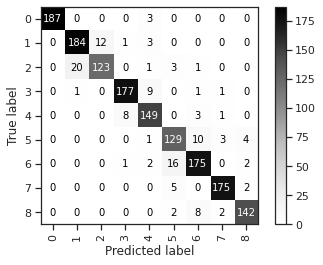

In [10]:
sns.set(font_scale = 1.0)
sns.set_style("ticks")
classification_complete_report(xgb, 
                               df_features.loc[test_index, classification_indx],
                               metadata.loc[test_index, "label"].replace(label_map))

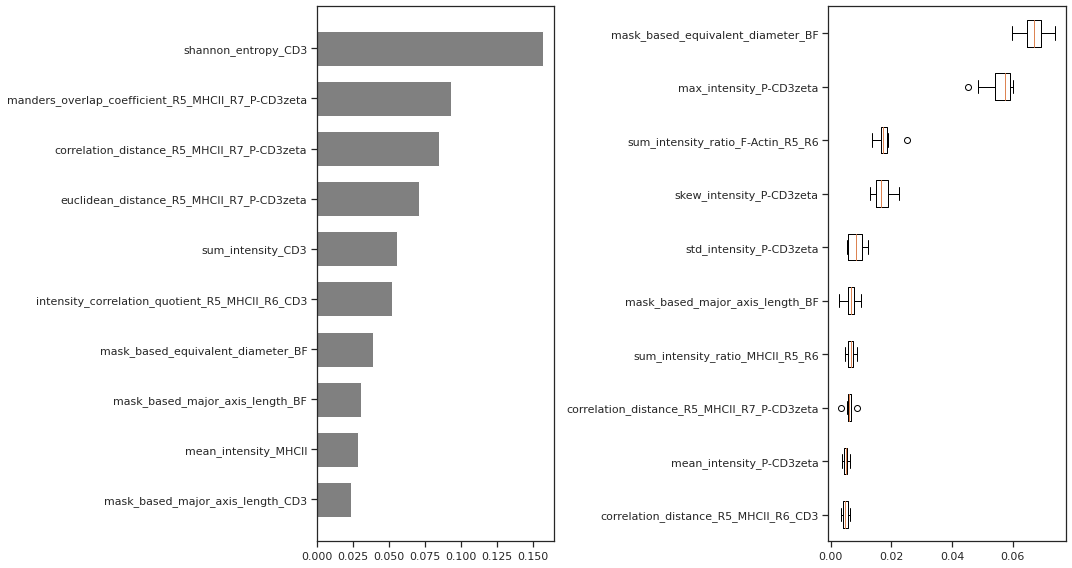

In [11]:
from sklearn.inspection import permutation_importance

selected_features = xgb.steps[1][1].selected_features
selected_feature_names = df_features.columns[classification_indx][selected_features]
selected_feature_names


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

tree_importance_sorted_idx = np.argsort(xgb.steps[2][1].feature_importances_)[-10:]

tree_indices = np.arange(0, 10) + 0.5

ax1.barh(tree_indices, 
         xgb.steps[2][1].feature_importances_[tree_importance_sorted_idx], 
         height=0.7, color  = "grey")
ax1.set_yticklabels(df_features.columns[classification_indx][selected_features].values[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)


result = permutation_importance(xgb, 
                                df_features.loc[test_index, classification_indx],
                                metadata.loc[test_index, "label"].replace(label_map), 
                                scoring="f1_macro",
                                n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()[-10:]
ax2.boxplot(result.importances[perm_sorted_idx].T, 
            vert=False,
            labels=df_features.columns[classification_indx].values[perm_sorted_idx])

fig.tight_layout()
#plt.savefig('feature_importance.svg', bbox_inches="tight")

# Permutation importance

In [12]:
from sklearn.model_selection import RepeatedStratifiedKFold
import shap
n_splits = 5
n_repeats = 100
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0)

all_train_index = train_index.tolist() + validation_index.tolist()
all_train_target = metadata.loc[train_index.tolist() + validation_index.tolist() , "label"].replace(label_map)

feature_importance_trees = pd.DataFrame(0., columns =  df_features.columns[classification_indx], index = range(n_splits*n_repeats))
feature_importance_permutation = pd.DataFrame(0., columns =  df_features.columns[classification_indx], index = range(n_splits*n_repeats))
feature_importance_shap = pd.DataFrame(0., columns =  df_features.columns[classification_indx], index = range(n_splits*n_repeats))

for i, (rskf_train_index, rskf_test_index) in enumerate(tqdm(rskf.split(all_train_index,all_train_target))):
    xgb_boost = Pipeline([
                ('StandardScaler', StandardScaler()), 
                ('AutoFeatureSelection', AutoFeatureSelection(top_k = random.randint(30,200))),
                 ('xgb', XGBClassifier(n_jobs = -1, 
                                       n_estimators = 100, 
                                       eval_metric = "logloss") )
        ], verbose=False)

    xgb_boost.fit(df_features.loc[all_train_index, classification_indx].iloc[rskf_train_index,:],  
                  metadata.loc[all_train_index, "label"].replace(label_map).iloc[rskf_train_index] )
    
    preds = xgb_boost.predict(df_features.loc[all_train_index, classification_indx].iloc[rskf_test_index,:])
    # Feature names
    selected_features = xgb_boost.steps[1][1].selected_features
    selected_feature_names = df_features.columns[classification_indx][selected_features]    
    
    # perfromance
    print("iteration", i+1,
          "num features:", len(selected_features),
          "performance", round(f1_score(metadata.loc[all_train_index, "label"].replace(label_map).iloc[rskf_test_index], 
                                        preds, average="macro" ),2))
    
    
    
    # trees importance
    feature_importance_trees.loc[i,selected_feature_names] = xgb_boost.steps[2][1].feature_importances_
    
    # permutation importance
    per_imp = permutation_importance(xgb_boost, 
                                     df_features.loc[all_train_index, classification_indx].iloc[rskf_test_index,:],
                                     metadata.loc[all_train_index, "label"].replace(label_map).iloc[rskf_test_index], 
                                     scoring="f1_macro",
                                     n_repeats=10,
                                     random_state=0)
    feature_importance_permutation.loc[i,:] = per_imp.importances_mean
     
    # SHAP importance

    X_transformed = xgb_boost.steps[0][1].transform(df_features.loc[all_train_index, classification_indx].iloc[rskf_test_index,:])
    X_transformed = xgb_boost.steps[1][1].transform(X_transformed)
    X_transformed = pd.DataFrame(X_transformed, columns=selected_feature_names)
    explainer = shap.TreeExplainer(xgb_boost.steps[-1][1])

    shap_values = explainer.shap_values(X_transformed)
    feature_importance_shap.loc[i,selected_feature_names] = np.abs(shap_values).mean(0).mean(0)

0it [00:00, ?it/s]

iteration 1 num features: 68 performance 0.92


1it [00:30, 30.73s/it]

iteration 2 num features: 37 performance 0.89


2it [01:00, 30.41s/it]

iteration 3 num features: 54 performance 0.92


3it [01:30, 30.09s/it]

iteration 4 num features: 134 performance 0.9


4it [02:00, 30.12s/it]

iteration 5 num features: 95 performance 0.92


5it [02:31, 30.33s/it]

iteration 6 num features: 152 performance 0.91


6it [03:02, 30.71s/it]

iteration 7 num features: 123 performance 0.92


7it [03:34, 31.10s/it]

iteration 8 num features: 84 performance 0.92


8it [04:05, 30.86s/it]

iteration 9 num features: 49 performance 0.91


9it [04:35, 30.55s/it]

iteration 10 num features: 120 performance 0.91


10it [05:06, 30.68s/it]

iteration 11 num features: 69 performance 0.92


11it [05:36, 30.57s/it]

iteration 12 num features: 150 performance 0.93


12it [06:07, 30.83s/it]

iteration 13 num features: 153 performance 0.9


13it [06:38, 30.93s/it]

iteration 14 num features: 140 performance 0.92


14it [07:09, 30.90s/it]

iteration 15 num features: 35 performance 0.88


15it [07:38, 30.32s/it]

iteration 16 num features: 92 performance 0.93


16it [08:09, 30.48s/it]

iteration 17 num features: 155 performance 0.93


17it [08:41, 31.02s/it]

iteration 18 num features: 147 performance 0.91


18it [09:12, 30.97s/it]

iteration 19 num features: 126 performance 0.91


19it [09:43, 30.93s/it]

iteration 20 num features: 103 performance 0.91


20it [10:13, 30.76s/it]

iteration 21 num features: 82 performance 0.92


21it [10:44, 30.71s/it]

iteration 22 num features: 68 performance 0.91


22it [11:14, 30.42s/it]

iteration 23 num features: 96 performance 0.91


23it [11:45, 30.60s/it]

iteration 24 num features: 61 performance 0.92


24it [12:14, 30.20s/it]

iteration 25 num features: 76 performance 0.92


25it [12:44, 30.18s/it]

iteration 26 num features: 112 performance 0.91


26it [13:16, 30.61s/it]

iteration 27 num features: 104 performance 0.92


27it [13:46, 30.51s/it]

iteration 28 num features: 143 performance 0.92


28it [14:19, 31.25s/it]

iteration 29 num features: 79 performance 0.89


29it [14:49, 30.86s/it]

iteration 30 num features: 148 performance 0.91


30it [15:20, 31.05s/it]

iteration 31 num features: 126 performance 0.9


31it [15:51, 30.98s/it]

iteration 32 num features: 155 performance 0.92


32it [16:23, 31.33s/it]

iteration 33 num features: 120 performance 0.91


33it [16:55, 31.29s/it]

iteration 34 num features: 55 performance 0.91


34it [17:24, 30.68s/it]

iteration 35 num features: 149 performance 0.91


35it [17:55, 30.81s/it]

iteration 36 num features: 151 performance 0.91


36it [18:26, 30.88s/it]

iteration 37 num features: 63 performance 0.92


37it [18:56, 30.63s/it]

iteration 38 num features: 122 performance 0.91


38it [19:27, 30.75s/it]

iteration 39 num features: 49 performance 0.9


39it [19:58, 30.65s/it]

iteration 40 num features: 154 performance 0.92


40it [20:30, 31.21s/it]

iteration 41 num features: 96 performance 0.92


41it [21:01, 31.08s/it]

iteration 42 num features: 152 performance 0.91


42it [21:33, 31.37s/it]

iteration 43 num features: 91 performance 0.93


43it [22:04, 31.25s/it]

iteration 44 num features: 98 performance 0.92


44it [22:35, 31.09s/it]

iteration 45 num features: 101 performance 0.91


45it [23:05, 31.02s/it]

iteration 46 num features: 152 performance 0.92


46it [23:37, 31.10s/it]

iteration 47 num features: 107 performance 0.91


47it [24:07, 30.96s/it]

iteration 48 num features: 154 performance 0.92


48it [24:39, 31.21s/it]

iteration 49 num features: 72 performance 0.92


49it [25:10, 31.08s/it]

iteration 50 num features: 114 performance 0.91


50it [25:41, 30.93s/it]

iteration 51 num features: 131 performance 0.92


51it [26:12, 31.08s/it]

iteration 52 num features: 38 performance 0.91


52it [26:41, 30.56s/it]

iteration 53 num features: 61 performance 0.92


53it [27:11, 30.36s/it]

iteration 54 num features: 30 performance 0.9


54it [27:41, 30.26s/it]

iteration 55 num features: 122 performance 0.9


55it [28:12, 30.32s/it]

iteration 56 num features: 144 performance 0.91


56it [28:43, 30.51s/it]

iteration 57 num features: 117 performance 0.92


57it [29:14, 30.73s/it]

iteration 58 num features: 156 performance 0.92


58it [29:46, 31.02s/it]

iteration 59 num features: 37 performance 0.91


59it [30:17, 31.03s/it]

iteration 60 num features: 66 performance 0.91


60it [30:46, 30.63s/it]

iteration 61 num features: 154 performance 0.92


61it [31:18, 31.03s/it]

iteration 62 num features: 129 performance 0.92


62it [31:49, 30.95s/it]

iteration 63 num features: 124 performance 0.92


63it [32:21, 31.18s/it]

iteration 64 num features: 149 performance 0.91


64it [32:52, 31.25s/it]

iteration 65 num features: 150 performance 0.91


65it [33:24, 31.55s/it]

iteration 66 num features: 46 performance 0.9


66it [33:53, 30.78s/it]

iteration 67 num features: 113 performance 0.9


67it [34:24, 30.58s/it]

iteration 68 num features: 149 performance 0.92


68it [34:56, 31.18s/it]

iteration 69 num features: 77 performance 0.9


69it [35:26, 30.91s/it]

iteration 70 num features: 130 performance 0.92


70it [35:58, 31.19s/it]

iteration 71 num features: 158 performance 0.91


71it [36:30, 31.29s/it]

iteration 72 num features: 83 performance 0.9


72it [37:00, 30.92s/it]

iteration 73 num features: 85 performance 0.91


73it [37:30, 30.70s/it]

iteration 74 num features: 54 performance 0.9


74it [38:00, 30.50s/it]

iteration 75 num features: 127 performance 0.92


75it [38:31, 30.54s/it]

iteration 76 num features: 124 performance 0.93


76it [39:02, 30.73s/it]

iteration 77 num features: 156 performance 0.9


77it [39:32, 30.66s/it]

iteration 78 num features: 120 performance 0.92


78it [40:03, 30.55s/it]

iteration 79 num features: 151 performance 0.91


79it [40:34, 30.70s/it]

iteration 80 num features: 78 performance 0.92


80it [41:05, 30.75s/it]

iteration 81 num features: 107 performance 0.92


81it [41:35, 30.57s/it]

iteration 82 num features: 57 performance 0.91


82it [42:04, 30.32s/it]

iteration 83 num features: 155 performance 0.92


83it [42:36, 30.61s/it]

iteration 84 num features: 92 performance 0.91


84it [43:06, 30.39s/it]

iteration 85 num features: 91 performance 0.91


85it [43:36, 30.41s/it]

iteration 86 num features: 154 performance 0.93


86it [44:08, 30.73s/it]

iteration 87 num features: 149 performance 0.9


87it [44:39, 31.02s/it]

iteration 88 num features: 95 performance 0.92


88it [45:09, 30.79s/it]

iteration 89 num features: 98 performance 0.92


89it [45:39, 30.50s/it]

iteration 90 num features: 108 performance 0.91


90it [46:10, 30.69s/it]

iteration 91 num features: 148 performance 0.94


91it [46:43, 31.14s/it]

iteration 92 num features: 120 performance 0.9


92it [47:13, 31.02s/it]

iteration 93 num features: 152 performance 0.93


93it [47:44, 31.04s/it]

iteration 94 num features: 49 performance 0.9


94it [48:14, 30.53s/it]

iteration 95 num features: 76 performance 0.9


95it [48:44, 30.55s/it]

iteration 96 num features: 46 performance 0.91


96it [49:15, 30.57s/it]

iteration 97 num features: 104 performance 0.91


97it [49:46, 30.82s/it]

iteration 98 num features: 57 performance 0.9


98it [50:16, 30.38s/it]

iteration 99 num features: 97 performance 0.91


99it [50:46, 30.34s/it]

iteration 100 num features: 155 performance 0.91


100it [51:18, 30.77s/it]

iteration 101 num features: 55 performance 0.91


101it [51:48, 30.54s/it]

iteration 102 num features: 99 performance 0.92


102it [52:18, 30.46s/it]

iteration 103 num features: 30 performance 0.88


103it [52:48, 30.18s/it]

iteration 104 num features: 137 performance 0.91


104it [53:19, 30.51s/it]

iteration 105 num features: 40 performance 0.89


105it [53:49, 30.29s/it]

iteration 106 num features: 124 performance 0.91


106it [54:20, 30.55s/it]

iteration 107 num features: 127 performance 0.91


107it [54:51, 30.67s/it]

iteration 108 num features: 155 performance 0.92


108it [55:22, 30.99s/it]

iteration 109 num features: 112 performance 0.92


109it [55:54, 31.02s/it]

iteration 110 num features: 154 performance 0.92


110it [56:26, 31.29s/it]

iteration 111 num features: 60 performance 0.9


111it [56:56, 31.05s/it]

iteration 112 num features: 151 performance 0.91


112it [57:28, 31.29s/it]

iteration 113 num features: 75 performance 0.91


113it [57:59, 31.11s/it]

iteration 114 num features: 133 performance 0.92


114it [58:30, 31.29s/it]

iteration 115 num features: 53 performance 0.9


115it [58:59, 30.64s/it]

iteration 116 num features: 59 performance 0.91


116it [59:30, 30.57s/it]

iteration 117 num features: 111 performance 0.9


117it [1:00:00, 30.61s/it]

iteration 118 num features: 152 performance 0.94


118it [1:00:33, 31.26s/it]

iteration 119 num features: 153 performance 0.91


119it [1:01:05, 31.53s/it]

iteration 120 num features: 110 performance 0.91


120it [1:01:36, 31.36s/it]

iteration 121 num features: 60 performance 0.92


121it [1:02:06, 30.76s/it]

iteration 122 num features: 46 performance 0.9


122it [1:02:35, 30.32s/it]

iteration 123 num features: 155 performance 0.91


123it [1:03:07, 30.79s/it]

iteration 124 num features: 50 performance 0.91


124it [1:03:37, 30.51s/it]

iteration 125 num features: 104 performance 0.91


125it [1:04:07, 30.34s/it]

iteration 126 num features: 104 performance 0.92


126it [1:04:37, 30.36s/it]

iteration 127 num features: 82 performance 0.93


127it [1:05:09, 30.67s/it]

iteration 128 num features: 120 performance 0.9


128it [1:05:39, 30.53s/it]

iteration 129 num features: 141 performance 0.91


129it [1:06:10, 30.64s/it]

iteration 130 num features: 130 performance 0.91


130it [1:06:41, 30.80s/it]

iteration 131 num features: 53 performance 0.9


131it [1:07:10, 30.32s/it]

iteration 132 num features: 85 performance 0.92


132it [1:07:39, 30.06s/it]

iteration 133 num features: 105 performance 0.92


133it [1:08:10, 30.21s/it]

iteration 134 num features: 56 performance 0.9


134it [1:08:40, 30.08s/it]

iteration 135 num features: 113 performance 0.91


135it [1:09:10, 30.15s/it]

iteration 136 num features: 111 performance 0.92


136it [1:09:40, 30.19s/it]

iteration 137 num features: 36 performance 0.92


137it [1:10:09, 29.80s/it]

iteration 138 num features: 152 performance 0.91


138it [1:10:41, 30.33s/it]

iteration 139 num features: 55 performance 0.9


139it [1:11:12, 30.47s/it]

iteration 140 num features: 156 performance 0.91


140it [1:11:43, 30.72s/it]

iteration 141 num features: 45 performance 0.9


141it [1:12:12, 30.22s/it]

iteration 142 num features: 149 performance 0.92


142it [1:12:43, 30.54s/it]

iteration 143 num features: 143 performance 0.92


143it [1:13:15, 30.86s/it]

iteration 144 num features: 151 performance 0.91


144it [1:13:47, 31.17s/it]

iteration 145 num features: 84 performance 0.93


145it [1:14:17, 30.75s/it]

iteration 146 num features: 149 performance 0.92


146it [1:14:48, 31.08s/it]

iteration 147 num features: 153 performance 0.92


147it [1:15:20, 31.09s/it]

iteration 148 num features: 45 performance 0.87


148it [1:15:50, 30.90s/it]

iteration 149 num features: 122 performance 0.92


149it [1:16:21, 31.04s/it]

iteration 150 num features: 56 performance 0.92


150it [1:16:51, 30.51s/it]

iteration 151 num features: 79 performance 0.92


151it [1:17:21, 30.49s/it]

iteration 152 num features: 149 performance 0.93


152it [1:17:53, 31.03s/it]

iteration 153 num features: 116 performance 0.91


153it [1:18:24, 30.89s/it]

iteration 154 num features: 47 performance 0.91


154it [1:18:55, 30.83s/it]

iteration 155 num features: 152 performance 0.9


155it [1:19:26, 30.85s/it]

iteration 156 num features: 72 performance 0.9


156it [1:19:55, 30.56s/it]

iteration 157 num features: 138 performance 0.91


157it [1:20:26, 30.64s/it]

iteration 158 num features: 106 performance 0.92


158it [1:20:57, 30.63s/it]

iteration 159 num features: 77 performance 0.92


159it [1:21:26, 30.29s/it]

iteration 160 num features: 89 performance 0.93


160it [1:21:57, 30.40s/it]

iteration 161 num features: 150 performance 0.92


161it [1:22:29, 30.82s/it]

iteration 162 num features: 155 performance 0.91


162it [1:23:00, 30.80s/it]

iteration 163 num features: 155 performance 0.91


163it [1:23:31, 31.07s/it]

iteration 164 num features: 45 performance 0.91


164it [1:24:01, 30.60s/it]

iteration 165 num features: 155 performance 0.91


165it [1:24:31, 30.56s/it]

iteration 166 num features: 65 performance 0.91


166it [1:25:01, 30.24s/it]

iteration 167 num features: 148 performance 0.93


167it [1:25:33, 30.81s/it]

iteration 168 num features: 137 performance 0.92


168it [1:26:04, 30.93s/it]

iteration 169 num features: 147 performance 0.91


169it [1:26:36, 31.27s/it]

iteration 170 num features: 41 performance 0.9


170it [1:27:06, 30.91s/it]

iteration 171 num features: 88 performance 0.92


171it [1:27:36, 30.73s/it]

iteration 172 num features: 43 performance 0.9


172it [1:28:06, 30.40s/it]

iteration 173 num features: 115 performance 0.91


173it [1:28:36, 30.20s/it]

iteration 174 num features: 135 performance 0.89


174it [1:29:06, 30.19s/it]

iteration 175 num features: 108 performance 0.93


175it [1:29:37, 30.28s/it]

iteration 176 num features: 147 performance 0.93


176it [1:30:08, 30.58s/it]

iteration 177 num features: 90 performance 0.92


177it [1:30:38, 30.39s/it]

iteration 178 num features: 70 performance 0.92


178it [1:31:08, 30.26s/it]

iteration 179 num features: 44 performance 0.91


179it [1:31:37, 30.08s/it]

iteration 180 num features: 90 performance 0.9


180it [1:32:07, 30.02s/it]

iteration 181 num features: 35 performance 0.9


181it [1:32:37, 30.00s/it]

iteration 182 num features: 46 performance 0.91


182it [1:33:06, 29.79s/it]

iteration 183 num features: 98 performance 0.92


183it [1:33:36, 29.84s/it]

iteration 184 num features: 96 performance 0.91


184it [1:34:07, 30.16s/it]

iteration 185 num features: 59 performance 0.9


185it [1:34:37, 29.97s/it]

iteration 186 num features: 35 performance 0.91


186it [1:35:06, 29.80s/it]

iteration 187 num features: 47 performance 0.9


187it [1:35:36, 29.87s/it]

iteration 188 num features: 133 performance 0.92


188it [1:36:08, 30.38s/it]

iteration 189 num features: 135 performance 0.92


189it [1:36:39, 30.62s/it]

iteration 190 num features: 146 performance 0.94


190it [1:37:11, 30.88s/it]

iteration 191 num features: 148 performance 0.91


191it [1:37:42, 31.07s/it]

iteration 192 num features: 151 performance 0.91


192it [1:38:13, 31.10s/it]

iteration 193 num features: 154 performance 0.91


193it [1:38:44, 31.11s/it]

iteration 194 num features: 108 performance 0.91


194it [1:39:15, 31.08s/it]

iteration 195 num features: 100 performance 0.93


195it [1:39:46, 30.85s/it]

iteration 196 num features: 49 performance 0.91


196it [1:40:16, 30.71s/it]

iteration 197 num features: 142 performance 0.9


197it [1:40:47, 30.84s/it]

iteration 198 num features: 144 performance 0.92


198it [1:41:19, 31.10s/it]

iteration 199 num features: 122 performance 0.91


199it [1:41:50, 31.16s/it]

iteration 200 num features: 35 performance 0.89


200it [1:42:20, 30.61s/it]

iteration 201 num features: 38 performance 0.91


201it [1:42:50, 30.47s/it]

iteration 202 num features: 155 performance 0.92


202it [1:43:22, 30.92s/it]

iteration 203 num features: 145 performance 0.91


203it [1:43:54, 31.44s/it]

iteration 204 num features: 37 performance 0.89


204it [1:44:25, 31.10s/it]

iteration 205 num features: 48 performance 0.89


205it [1:44:54, 30.49s/it]

iteration 206 num features: 155 performance 0.91


206it [1:45:26, 31.04s/it]

iteration 207 num features: 39 performance 0.91


207it [1:45:57, 30.88s/it]

iteration 208 num features: 68 performance 0.91


208it [1:46:27, 30.66s/it]

iteration 209 num features: 156 performance 0.92


209it [1:46:59, 31.12s/it]

iteration 210 num features: 146 performance 0.91


210it [1:47:30, 31.14s/it]

iteration 211 num features: 76 performance 0.91


211it [1:48:00, 30.83s/it]

iteration 212 num features: 30 performance 0.9


212it [1:48:30, 30.58s/it]

iteration 213 num features: 80 performance 0.91


213it [1:49:01, 30.57s/it]

iteration 214 num features: 98 performance 0.92


214it [1:49:31, 30.54s/it]

iteration 215 num features: 153 performance 0.93


215it [1:50:03, 31.05s/it]

iteration 216 num features: 155 performance 0.93


216it [1:50:35, 31.28s/it]

iteration 217 num features: 123 performance 0.91


217it [1:51:07, 31.51s/it]

iteration 218 num features: 65 performance 0.91


218it [1:51:37, 30.93s/it]

iteration 219 num features: 81 performance 0.9


219it [1:52:07, 30.64s/it]

iteration 220 num features: 33 performance 0.9


220it [1:52:36, 30.24s/it]

iteration 221 num features: 84 performance 0.9


221it [1:53:06, 30.17s/it]

iteration 222 num features: 47 performance 0.91


222it [1:53:36, 30.17s/it]

iteration 223 num features: 134 performance 0.92


223it [1:54:07, 30.43s/it]

iteration 224 num features: 95 performance 0.91


224it [1:54:39, 30.91s/it]

iteration 225 num features: 40 performance 0.91


225it [1:55:08, 30.35s/it]

iteration 226 num features: 32 performance 0.9


226it [1:55:39, 30.40s/it]

iteration 227 num features: 95 performance 0.91


227it [1:56:10, 30.66s/it]

iteration 228 num features: 59 performance 0.91


228it [1:56:41, 30.68s/it]

iteration 229 num features: 148 performance 0.92


229it [1:57:13, 31.24s/it]

iteration 230 num features: 120 performance 0.91


230it [1:57:46, 31.52s/it]

iteration 231 num features: 148 performance 0.92


231it [1:58:19, 31.97s/it]

iteration 232 num features: 147 performance 0.92


232it [1:58:50, 31.79s/it]

iteration 233 num features: 132 performance 0.93


233it [1:59:21, 31.46s/it]

iteration 234 num features: 156 performance 0.91


234it [1:59:52, 31.27s/it]

iteration 235 num features: 114 performance 0.91


235it [2:00:22, 31.15s/it]

iteration 236 num features: 149 performance 0.91


236it [2:00:54, 31.40s/it]

iteration 237 num features: 107 performance 0.91


237it [2:01:25, 31.05s/it]

iteration 238 num features: 118 performance 0.91


238it [2:01:56, 31.03s/it]

iteration 239 num features: 110 performance 0.93


239it [2:02:27, 31.02s/it]

iteration 240 num features: 138 performance 0.92


240it [2:02:57, 30.90s/it]

iteration 241 num features: 60 performance 0.9


241it [2:03:27, 30.56s/it]

iteration 242 num features: 151 performance 0.93


242it [2:03:57, 30.48s/it]

iteration 243 num features: 80 performance 0.9


243it [2:04:27, 30.23s/it]

iteration 244 num features: 151 performance 0.92


244it [2:04:58, 30.42s/it]

iteration 245 num features: 130 performance 0.92


245it [2:05:28, 30.29s/it]

iteration 246 num features: 71 performance 0.92


246it [2:05:58, 30.14s/it]

iteration 247 num features: 145 performance 0.91


247it [2:06:28, 30.36s/it]

iteration 248 num features: 50 performance 0.91


248it [2:06:57, 29.83s/it]

iteration 249 num features: 68 performance 0.92


249it [2:07:27, 29.96s/it]

iteration 250 num features: 53 performance 0.91


250it [2:07:56, 29.66s/it]

iteration 251 num features: 65 performance 0.9


251it [2:08:26, 29.67s/it]

iteration 252 num features: 55 performance 0.89


252it [2:08:55, 29.39s/it]

iteration 253 num features: 152 performance 0.91


253it [2:09:25, 29.74s/it]

iteration 254 num features: 153 performance 0.93


254it [2:09:56, 30.11s/it]

iteration 255 num features: 42 performance 0.91


255it [2:10:26, 29.89s/it]

iteration 256 num features: 61 performance 0.9


256it [2:10:56, 29.91s/it]

iteration 257 num features: 85 performance 0.91


257it [2:11:25, 29.76s/it]

iteration 258 num features: 157 performance 0.93


258it [2:11:56, 30.03s/it]

iteration 259 num features: 156 performance 0.92


259it [2:12:27, 30.38s/it]

iteration 260 num features: 107 performance 0.92


260it [2:12:57, 30.34s/it]

iteration 261 num features: 152 performance 0.94


261it [2:13:29, 30.74s/it]

iteration 262 num features: 144 performance 0.92


262it [2:14:00, 30.79s/it]

iteration 263 num features: 45 performance 0.9


263it [2:14:30, 30.70s/it]

iteration 264 num features: 153 performance 0.93


264it [2:15:02, 30.91s/it]

iteration 265 num features: 88 performance 0.9


265it [2:15:31, 30.41s/it]

iteration 266 num features: 52 performance 0.9


266it [2:16:00, 30.06s/it]

iteration 267 num features: 95 performance 0.92


267it [2:16:30, 30.05s/it]

iteration 268 num features: 113 performance 0.93


268it [2:17:00, 30.17s/it]

iteration 269 num features: 88 performance 0.92


269it [2:17:31, 30.36s/it]

iteration 270 num features: 48 performance 0.88


270it [2:18:00, 29.96s/it]

iteration 271 num features: 153 performance 0.92


271it [2:18:31, 30.13s/it]

iteration 272 num features: 107 performance 0.93


272it [2:19:02, 30.31s/it]

iteration 273 num features: 148 performance 0.92


273it [2:19:33, 30.51s/it]

iteration 274 num features: 147 performance 0.91


274it [2:20:04, 30.92s/it]

iteration 275 num features: 126 performance 0.9


275it [2:20:35, 30.77s/it]

iteration 276 num features: 126 performance 0.91


276it [2:21:06, 30.83s/it]

iteration 277 num features: 141 performance 0.92


277it [2:21:37, 31.04s/it]

iteration 278 num features: 139 performance 0.92


278it [2:22:08, 30.82s/it]

iteration 279 num features: 75 performance 0.92


279it [2:22:38, 30.78s/it]

iteration 280 num features: 153 performance 0.91


280it [2:23:09, 30.77s/it]

iteration 281 num features: 156 performance 0.93


281it [2:23:40, 30.91s/it]

iteration 282 num features: 154 performance 0.91


282it [2:24:13, 31.38s/it]

iteration 283 num features: 64 performance 0.91


283it [2:24:42, 30.86s/it]

iteration 284 num features: 34 performance 0.91


284it [2:25:12, 30.35s/it]

iteration 285 num features: 149 performance 0.9


285it [2:25:43, 30.61s/it]

iteration 286 num features: 41 performance 0.9


286it [2:26:13, 30.43s/it]

iteration 287 num features: 151 performance 0.91


287it [2:26:44, 30.57s/it]

iteration 288 num features: 120 performance 0.92


288it [2:27:15, 30.80s/it]

iteration 289 num features: 154 performance 0.91


289it [2:27:47, 31.06s/it]

iteration 290 num features: 75 performance 0.92


290it [2:28:16, 30.60s/it]

iteration 291 num features: 153 performance 0.93


291it [2:28:47, 30.73s/it]

iteration 292 num features: 46 performance 0.9


292it [2:29:17, 30.46s/it]

iteration 293 num features: 46 performance 0.92


293it [2:29:46, 29.92s/it]

iteration 294 num features: 112 performance 0.91


294it [2:30:17, 30.17s/it]

iteration 295 num features: 115 performance 0.92


295it [2:30:46, 30.07s/it]

iteration 296 num features: 103 performance 0.92


296it [2:31:17, 30.18s/it]

iteration 297 num features: 40 performance 0.88


297it [2:31:46, 29.94s/it]

iteration 298 num features: 61 performance 0.9


298it [2:32:16, 29.78s/it]

iteration 299 num features: 73 performance 0.91


299it [2:32:45, 29.66s/it]

iteration 300 num features: 34 performance 0.9


300it [2:33:15, 29.64s/it]

iteration 301 num features: 155 performance 0.92


301it [2:33:46, 30.19s/it]

iteration 302 num features: 76 performance 0.93


302it [2:34:17, 30.35s/it]

iteration 303 num features: 152 performance 0.92


303it [2:34:48, 30.75s/it]

iteration 304 num features: 155 performance 0.92


304it [2:35:20, 31.02s/it]

iteration 305 num features: 47 performance 0.89


305it [2:35:49, 30.46s/it]

iteration 306 num features: 75 performance 0.92


306it [2:36:20, 30.49s/it]

iteration 307 num features: 134 performance 0.92


307it [2:36:50, 30.45s/it]

iteration 308 num features: 150 performance 0.91


308it [2:37:21, 30.44s/it]

iteration 309 num features: 151 performance 0.88


309it [2:37:51, 30.54s/it]

iteration 310 num features: 84 performance 0.91


310it [2:38:21, 30.37s/it]

iteration 311 num features: 152 performance 0.92


311it [2:38:52, 30.53s/it]

iteration 312 num features: 143 performance 0.94


312it [2:39:24, 30.94s/it]

iteration 313 num features: 131 performance 0.93


313it [2:39:55, 30.83s/it]

iteration 314 num features: 64 performance 0.89


314it [2:40:24, 30.46s/it]

iteration 315 num features: 57 performance 0.91


315it [2:40:53, 30.00s/it]

iteration 316 num features: 42 performance 0.91


316it [2:41:22, 29.78s/it]

iteration 317 num features: 125 performance 0.9


317it [2:41:53, 30.01s/it]

iteration 318 num features: 95 performance 0.91


318it [2:42:23, 30.08s/it]

iteration 319 num features: 41 performance 0.92


319it [2:42:53, 29.92s/it]

iteration 320 num features: 123 performance 0.92


320it [2:43:23, 30.12s/it]

iteration 321 num features: 72 performance 0.92


321it [2:43:54, 30.35s/it]

iteration 322 num features: 46 performance 0.9


322it [2:44:24, 30.16s/it]

iteration 323 num features: 152 performance 0.92


323it [2:44:57, 30.90s/it]

iteration 324 num features: 62 performance 0.9


324it [2:45:26, 30.40s/it]

iteration 325 num features: 143 performance 0.9


325it [2:45:58, 30.96s/it]

iteration 326 num features: 53 performance 0.93


326it [2:46:29, 31.07s/it]

iteration 327 num features: 96 performance 0.9


327it [2:47:01, 31.32s/it]

iteration 328 num features: 127 performance 0.91


328it [2:47:33, 31.38s/it]

iteration 329 num features: 152 performance 0.89


329it [2:48:05, 31.73s/it]

iteration 330 num features: 57 performance 0.9


330it [2:48:36, 31.53s/it]

iteration 331 num features: 70 performance 0.91


331it [2:49:09, 31.87s/it]

iteration 332 num features: 152 performance 0.91


332it [2:49:42, 32.29s/it]

iteration 333 num features: 40 performance 0.91


333it [2:50:12, 31.36s/it]

iteration 334 num features: 49 performance 0.91


334it [2:50:42, 30.93s/it]

iteration 335 num features: 47 performance 0.9


335it [2:51:11, 30.40s/it]

iteration 336 num features: 152 performance 0.92


336it [2:51:42, 30.62s/it]

iteration 337 num features: 122 performance 0.92


337it [2:52:13, 30.68s/it]

iteration 338 num features: 68 performance 0.89


338it [2:52:42, 30.18s/it]

iteration 339 num features: 97 performance 0.92


339it [2:53:12, 30.10s/it]

iteration 340 num features: 56 performance 0.92


340it [2:53:42, 30.09s/it]

iteration 341 num features: 35 performance 0.9


341it [2:54:11, 29.75s/it]

iteration 342 num features: 108 performance 0.91


342it [2:54:41, 29.86s/it]

iteration 343 num features: 147 performance 0.91


343it [2:55:11, 30.08s/it]

iteration 344 num features: 147 performance 0.91


344it [2:55:41, 30.07s/it]

iteration 345 num features: 153 performance 0.92


345it [2:56:12, 30.39s/it]

iteration 346 num features: 110 performance 0.93


346it [2:56:43, 30.33s/it]

iteration 347 num features: 150 performance 0.92


347it [2:57:13, 30.39s/it]

iteration 348 num features: 155 performance 0.9


348it [2:57:44, 30.41s/it]

iteration 349 num features: 155 performance 0.93


349it [2:58:14, 30.39s/it]

iteration 350 num features: 87 performance 0.89


350it [2:58:44, 30.19s/it]

iteration 351 num features: 127 performance 0.92


351it [2:59:15, 30.44s/it]

iteration 352 num features: 86 performance 0.93


352it [2:59:45, 30.28s/it]

iteration 353 num features: 137 performance 0.91


353it [3:00:14, 30.09s/it]

iteration 354 num features: 152 performance 0.91


354it [3:00:45, 30.37s/it]

iteration 355 num features: 82 performance 0.91


355it [3:01:15, 30.03s/it]

iteration 356 num features: 47 performance 0.92


356it [3:01:44, 29.89s/it]

iteration 357 num features: 149 performance 0.92


357it [3:02:16, 30.45s/it]

iteration 358 num features: 116 performance 0.91


358it [3:02:46, 30.28s/it]

iteration 359 num features: 123 performance 0.93


359it [3:03:16, 30.19s/it]

iteration 360 num features: 154 performance 0.91


360it [3:03:46, 30.17s/it]

iteration 361 num features: 121 performance 0.92


361it [3:04:16, 30.15s/it]

iteration 362 num features: 144 performance 0.94


362it [3:04:46, 30.25s/it]

iteration 363 num features: 83 performance 0.91


363it [3:05:17, 30.23s/it]

iteration 364 num features: 65 performance 0.92


364it [3:05:46, 30.09s/it]

iteration 365 num features: 149 performance 0.9


365it [3:06:16, 30.08s/it]

iteration 366 num features: 94 performance 0.92


366it [3:06:46, 29.98s/it]

iteration 367 num features: 126 performance 0.93


367it [3:07:17, 30.15s/it]

iteration 368 num features: 154 performance 0.91


368it [3:07:48, 30.36s/it]

iteration 369 num features: 51 performance 0.9


369it [3:08:17, 30.03s/it]

iteration 370 num features: 111 performance 0.93


370it [3:08:47, 29.93s/it]

iteration 371 num features: 126 performance 0.9


371it [3:09:17, 30.09s/it]

iteration 372 num features: 145 performance 0.93


372it [3:09:47, 30.10s/it]

iteration 373 num features: 96 performance 0.92


373it [3:10:17, 30.04s/it]

iteration 374 num features: 154 performance 0.91


374it [3:10:48, 30.30s/it]

iteration 375 num features: 154 performance 0.92


375it [3:11:19, 30.48s/it]

iteration 376 num features: 138 performance 0.91


376it [3:11:49, 30.31s/it]

iteration 377 num features: 114 performance 0.93


377it [3:12:19, 30.31s/it]

iteration 378 num features: 58 performance 0.89


378it [3:12:48, 29.87s/it]

iteration 379 num features: 50 performance 0.91


379it [3:13:17, 29.57s/it]

iteration 380 num features: 77 performance 0.92


380it [3:13:46, 29.52s/it]

iteration 381 num features: 149 performance 0.93


381it [3:14:17, 29.82s/it]

iteration 382 num features: 45 performance 0.9


382it [3:14:46, 29.79s/it]

iteration 383 num features: 144 performance 0.91


383it [3:15:16, 29.85s/it]

iteration 384 num features: 152 performance 0.93


384it [3:15:47, 29.98s/it]

iteration 385 num features: 100 performance 0.91


385it [3:16:17, 30.02s/it]

iteration 386 num features: 154 performance 0.93


386it [3:16:48, 30.22s/it]

iteration 387 num features: 38 performance 0.89


387it [3:17:16, 29.63s/it]

iteration 388 num features: 155 performance 0.92


388it [3:17:47, 30.26s/it]

iteration 389 num features: 87 performance 0.93


389it [3:18:18, 30.25s/it]

iteration 390 num features: 36 performance 0.89


390it [3:18:48, 30.27s/it]

iteration 391 num features: 65 performance 0.9


391it [3:19:16, 29.69s/it]

iteration 392 num features: 54 performance 0.9


392it [3:19:46, 29.76s/it]

iteration 393 num features: 76 performance 0.92


393it [3:20:17, 29.96s/it]

iteration 394 num features: 147 performance 0.94


394it [3:20:48, 30.37s/it]

iteration 395 num features: 147 performance 0.93


395it [3:21:20, 30.70s/it]

iteration 396 num features: 101 performance 0.92


396it [3:21:50, 30.68s/it]

iteration 397 num features: 156 performance 0.92


397it [3:22:21, 30.80s/it]

iteration 398 num features: 104 performance 0.91


398it [3:22:51, 30.56s/it]

iteration 399 num features: 66 performance 0.91


399it [3:23:20, 30.11s/it]

iteration 400 num features: 151 performance 0.91


400it [3:23:51, 30.26s/it]

iteration 401 num features: 152 performance 0.91


401it [3:24:22, 30.38s/it]

iteration 402 num features: 148 performance 0.92


402it [3:24:54, 30.97s/it]

iteration 403 num features: 54 performance 0.92


403it [3:25:24, 30.56s/it]

iteration 404 num features: 132 performance 0.92


404it [3:25:54, 30.56s/it]

iteration 405 num features: 98 performance 0.91


405it [3:26:24, 30.33s/it]

iteration 406 num features: 99 performance 0.9


406it [3:26:55, 30.53s/it]

iteration 407 num features: 67 performance 0.91


407it [3:27:25, 30.37s/it]

iteration 408 num features: 146 performance 0.92


408it [3:27:55, 30.41s/it]

iteration 409 num features: 83 performance 0.91


409it [3:28:25, 30.13s/it]

iteration 410 num features: 73 performance 0.91


410it [3:28:54, 29.91s/it]

iteration 411 num features: 122 performance 0.91


411it [3:29:25, 30.05s/it]

iteration 412 num features: 116 performance 0.91


412it [3:29:55, 30.27s/it]

iteration 413 num features: 147 performance 0.94


413it [3:30:27, 30.52s/it]

iteration 414 num features: 139 performance 0.93


414it [3:30:57, 30.50s/it]

iteration 415 num features: 95 performance 0.9


415it [3:31:27, 30.38s/it]

iteration 416 num features: 147 performance 0.91


416it [3:31:58, 30.65s/it]

iteration 417 num features: 151 performance 0.92


417it [3:32:29, 30.77s/it]

iteration 418 num features: 145 performance 0.92


418it [3:33:01, 30.91s/it]

iteration 419 num features: 101 performance 0.91


419it [3:33:31, 30.69s/it]

iteration 420 num features: 158 performance 0.9


420it [3:34:02, 30.69s/it]

iteration 421 num features: 152 performance 0.92


421it [3:34:33, 30.96s/it]

iteration 422 num features: 153 performance 0.92


422it [3:35:04, 30.88s/it]

iteration 423 num features: 156 performance 0.92


423it [3:35:34, 30.76s/it]

iteration 424 num features: 124 performance 0.91


424it [3:36:06, 30.92s/it]

iteration 425 num features: 50 performance 0.91


425it [3:36:35, 30.59s/it]

iteration 426 num features: 146 performance 0.92


426it [3:37:06, 30.74s/it]

iteration 427 num features: 59 performance 0.9


427it [3:37:37, 30.63s/it]

iteration 428 num features: 157 performance 0.93


428it [3:38:10, 31.45s/it]

iteration 429 num features: 146 performance 0.91


429it [3:38:42, 31.42s/it]

iteration 430 num features: 154 performance 0.9


430it [3:39:14, 31.72s/it]

iteration 431 num features: 155 performance 0.92


431it [3:39:45, 31.65s/it]

iteration 432 num features: 75 performance 0.92


432it [3:40:15, 31.02s/it]

iteration 433 num features: 136 performance 0.91


433it [3:40:46, 31.16s/it]

iteration 434 num features: 60 performance 0.91


434it [3:41:16, 30.79s/it]

iteration 435 num features: 124 performance 0.91


435it [3:41:47, 30.81s/it]

iteration 436 num features: 49 performance 0.94


436it [3:42:17, 30.51s/it]

iteration 437 num features: 40 performance 0.9


437it [3:42:47, 30.42s/it]

iteration 438 num features: 67 performance 0.9


438it [3:43:17, 30.25s/it]

iteration 439 num features: 70 performance 0.89


439it [3:43:47, 30.17s/it]

iteration 440 num features: 68 performance 0.93


440it [3:44:16, 29.82s/it]

iteration 441 num features: 102 performance 0.92


441it [3:44:47, 30.06s/it]

iteration 442 num features: 137 performance 0.93


442it [3:45:19, 30.56s/it]

iteration 443 num features: 136 performance 0.91


443it [3:45:49, 30.47s/it]

iteration 444 num features: 114 performance 0.92


444it [3:46:20, 30.65s/it]

iteration 445 num features: 79 performance 0.92


445it [3:46:50, 30.61s/it]

iteration 446 num features: 152 performance 0.92


446it [3:47:22, 30.85s/it]

iteration 447 num features: 151 performance 0.91


447it [3:47:53, 30.83s/it]

iteration 448 num features: 87 performance 0.93


448it [3:48:23, 30.68s/it]

iteration 449 num features: 126 performance 0.92


449it [3:48:53, 30.61s/it]

iteration 450 num features: 130 performance 0.91


450it [3:49:24, 30.51s/it]

iteration 451 num features: 41 performance 0.92


451it [3:49:53, 30.21s/it]

iteration 452 num features: 64 performance 0.91


452it [3:50:23, 30.06s/it]

iteration 453 num features: 43 performance 0.91


453it [3:50:52, 29.78s/it]

iteration 454 num features: 139 performance 0.93


454it [3:51:23, 30.22s/it]

iteration 455 num features: 155 performance 0.89


455it [3:51:54, 30.47s/it]

iteration 456 num features: 153 performance 0.91


456it [3:52:26, 30.88s/it]

iteration 457 num features: 39 performance 0.91


457it [3:52:56, 30.68s/it]

iteration 458 num features: 154 performance 0.92


458it [3:53:28, 31.04s/it]

iteration 459 num features: 150 performance 0.9


459it [3:54:00, 31.30s/it]

iteration 460 num features: 152 performance 0.92


460it [3:54:32, 31.43s/it]

iteration 461 num features: 124 performance 0.92


461it [3:55:03, 31.35s/it]

iteration 462 num features: 85 performance 0.89


462it [3:55:33, 30.85s/it]

iteration 463 num features: 74 performance 0.92


463it [3:56:02, 30.54s/it]

iteration 464 num features: 65 performance 0.92


464it [3:56:32, 30.26s/it]

iteration 465 num features: 104 performance 0.92


465it [3:57:02, 30.09s/it]

iteration 466 num features: 40 performance 0.9


466it [3:57:31, 29.86s/it]

iteration 467 num features: 151 performance 0.92


467it [3:58:03, 30.56s/it]

iteration 468 num features: 155 performance 0.91


468it [3:58:35, 30.79s/it]

iteration 469 num features: 150 performance 0.91


469it [3:59:06, 30.92s/it]

iteration 470 num features: 154 performance 0.9


470it [3:59:37, 30.97s/it]

iteration 471 num features: 117 performance 0.92


471it [4:00:07, 30.76s/it]

iteration 472 num features: 151 performance 0.92


472it [4:00:38, 30.83s/it]

iteration 473 num features: 45 performance 0.9


473it [4:01:08, 30.45s/it]

iteration 474 num features: 143 performance 0.92


474it [4:01:39, 30.68s/it]

iteration 475 num features: 140 performance 0.92


475it [4:02:10, 30.79s/it]

iteration 476 num features: 57 performance 0.91


476it [4:02:40, 30.40s/it]

iteration 477 num features: 55 performance 0.9


477it [4:03:09, 30.23s/it]

iteration 478 num features: 149 performance 0.91


478it [4:03:40, 30.35s/it]

iteration 479 num features: 60 performance 0.93


479it [4:04:09, 30.04s/it]

iteration 480 num features: 103 performance 0.92


480it [4:04:40, 30.24s/it]

iteration 481 num features: 140 performance 0.92


481it [4:05:11, 30.36s/it]

iteration 482 num features: 116 performance 0.9


482it [4:05:41, 30.36s/it]

iteration 483 num features: 154 performance 0.92


483it [4:06:13, 30.80s/it]

iteration 484 num features: 151 performance 0.91


484it [4:06:44, 30.86s/it]

iteration 485 num features: 109 performance 0.91


485it [4:07:15, 31.02s/it]

iteration 486 num features: 39 performance 0.88


486it [4:07:44, 30.25s/it]

iteration 487 num features: 116 performance 0.93


487it [4:08:14, 30.41s/it]

iteration 488 num features: 79 performance 0.91


488it [4:08:45, 30.30s/it]

iteration 489 num features: 155 performance 0.92


489it [4:09:16, 30.60s/it]

iteration 490 num features: 121 performance 0.93


490it [4:09:47, 30.70s/it]

iteration 491 num features: 49 performance 0.91


491it [4:10:16, 30.37s/it]

iteration 492 num features: 131 performance 0.92


492it [4:10:47, 30.59s/it]

iteration 493 num features: 66 performance 0.91


493it [4:11:17, 30.16s/it]

iteration 494 num features: 153 performance 0.9


494it [4:11:48, 30.53s/it]

iteration 495 num features: 85 performance 0.92


495it [4:12:17, 30.10s/it]

iteration 496 num features: 86 performance 0.92


496it [4:12:46, 29.88s/it]

iteration 497 num features: 68 performance 0.91


497it [4:13:15, 29.60s/it]

iteration 498 num features: 150 performance 0.93


498it [4:13:47, 30.06s/it]

iteration 499 num features: 30 performance 0.9


499it [4:14:15, 29.71s/it]

iteration 500 num features: 77 performance 0.89


500it [4:14:45, 30.57s/it]


In [ ]:
feature_importance_trees.iloc[:,:].quantile(0.50).sort_values(ascending=False).iloc[:9].index

In [187]:
feature_importance_trees.iloc[:,:].quantile(0.50).sort_values(ascending=False).iloc[:9].index

Index(['sum_intensity_CD3',
       'manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta',
       'euclidean_distance_R5_MHCII_R7_P-CD3zeta',
       'intensity_correlation_quotient_R5_MHCII_R6_CD3',
       'correlation_distance_R5_MHCII_R6_CD3',
       'mask_based_equivalent_diameter_BF', 'mean_intensity_MHCII',
       'sum_intensity_ratio_MHCII_R5_R6', 'contrast_MHCII'],
      dtype='object')

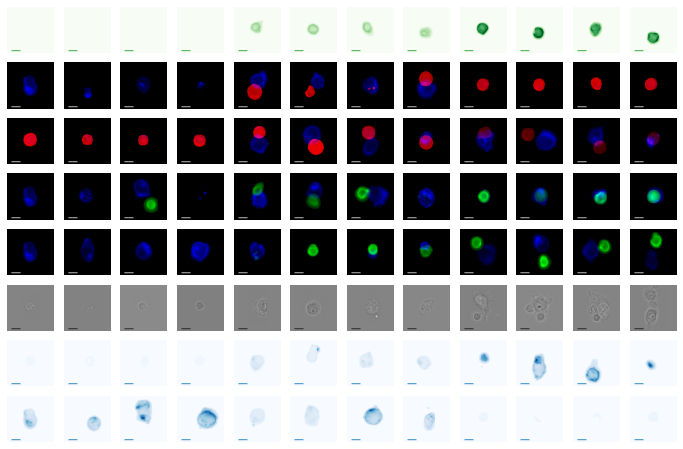

In [188]:
from skimage.util import crop
from skimage.exposure import rescale_intensity
import h5py


# BF,  F-Actin, MHCII, CD3, P-CD3zeta
# channels_cmap = ["Greys", "Oranges","Blues","Greens", "Reds"]
# nrows = 10
# ncols = 3
# image_size = 128
# channels =[0,3,4,5,6]


image_size = 128
nrows = 8
ncols = 12
figsize = (ncols,nrows)
plt.rcParams["axes.grid"] = False
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for i  in range(nrows) : 
    ax[i,0].set_ylabel("")
    
for j  in range(ncols) : 
    ax[0,j].set_xlabel("")  
    

################################################################
i = 0
col = "sum_intensity_CD3"
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [5]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if j>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Greens", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
    

################################################################
i = 1
col = "manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta"
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()
    
    
channels_to_be_plotted = [6,5,4]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = np.zeros((image_size, image_size , len(channels_to_be_plotted)))
    for k,ch in enumerate(channels_to_be_plotted):
        image_dummy_ch = crop(image[:,:,k]*mask[:,:,k], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
        image_dummy_ch = np.pad(image_dummy_ch, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
        image_dummy[:,:,k] = rescale_intensity(image_dummy_ch, in_range = (vmin[k], vmax[k]), out_range = (0.,1.))
    
    image_dummy[:,:,1] = 0.
    image_dummy = image_dummy / image_dummy.max()
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25),:] =  1.
    
    ax[i,j].imshow( image_dummy)
    data.close()



################################################################
i = 2
col = "euclidean_distance_R5_MHCII_R7_P-CD3zeta"
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()
    
    
channels_to_be_plotted = [6,5,4]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = np.zeros((image_size, image_size , len(channels_to_be_plotted)))
    for k,ch in enumerate(channels_to_be_plotted):
        image_dummy_ch = crop(image[:,:,k]*mask[:,:,k], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
        image_dummy_ch = np.pad(image_dummy_ch, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
        image_dummy[:,:,k] = rescale_intensity(image_dummy_ch, in_range = (vmin[k], vmax[k]), out_range = (0.,1.))
    
    image_dummy[:,:,1] = 0.
    image_dummy = image_dummy / image_dummy.max()
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25),:] =  1.
    
    ax[i,j].imshow( image_dummy)
    data.close()
    
################################################################
i = 3
col = 'intensity_correlation_quotient_R5_MHCII_R6_CD3'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()
    
    
channels_to_be_plotted = [6,5,4]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = np.zeros((image_size, image_size , len(channels_to_be_plotted)))
    for k,ch in enumerate(channels_to_be_plotted):
        image_dummy_ch = crop(image[:,:,k]*mask[:,:,k], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
        image_dummy_ch = np.pad(image_dummy_ch, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
        image_dummy[:,:,k] = rescale_intensity(image_dummy_ch, in_range = (vmin[k], vmax[k]), out_range = (0.,1.))
    
    image_dummy[:,:,0] = 0.
    image_dummy = image_dummy / image_dummy.max()
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25),:] =  1.
    
    ax[i,j].imshow( image_dummy)
    data.close()
    
################################################################
i = 4
col = 'correlation_distance_R5_MHCII_R6_CD3'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()
    
    
channels_to_be_plotted = [6,5,4]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = np.zeros((image_size, image_size , len(channels_to_be_plotted)))
    for k,ch in enumerate(channels_to_be_plotted):
        image_dummy_ch = crop(image[:,:,k]*mask[:,:,k], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
        image_dummy_ch = np.pad(image_dummy_ch, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
        image_dummy[:,:,k] = rescale_intensity(image_dummy_ch, in_range = (vmin[k], vmax[k]), out_range = (0.,1.))
    
    image_dummy[:,:,0] = 0.
    image_dummy = image_dummy / image_dummy.max()
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25),:] =  1.
    
    ax[i,j].imshow( image_dummy)
    data.close()
    
    
################################################################
i = 5
col = 'mask_based_equivalent_diameter_BF'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [0]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    #image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Greys", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
    
################################################################
i = 6
col = 'mean_intensity_MHCII'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [4]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Blues", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
    
################################################################
i = 7
col = 'sum_intensity_ratio_MHCII_R5_R6'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [4]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Blues", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
    
plt.savefig('Figure 1 - most importance features.svg', bbox_inches="tight")

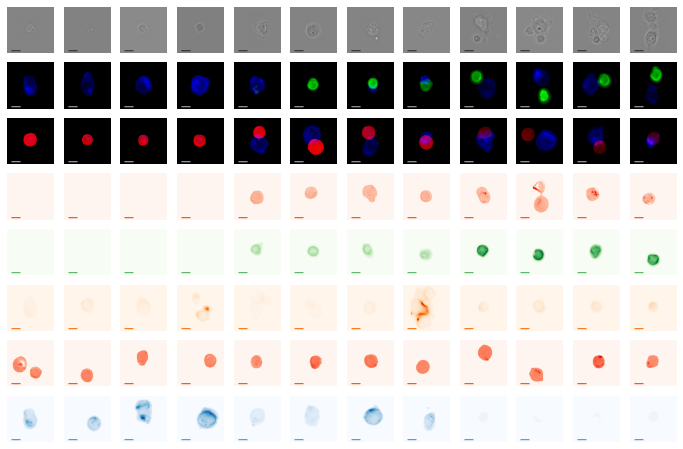

In [189]:

image_size = 128
nrows = 8
ncols = 12
figsize = (ncols,nrows)
plt.rcParams["axes.grid"] = False
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for i  in range(nrows) : 
    ax[i,0].set_ylabel("")
    
for j  in range(ncols) : 
    ax[0,j].set_xlabel("")  
    

################################################################
i = 0
col = "mask_based_equivalent_diameter_BF"
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [0]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    #image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Greys", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
################################################################
i = 1
col = 'correlation_distance_R5_MHCII_R6_CD3'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()
    
    
channels_to_be_plotted = [6,5,4]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = np.zeros((image_size, image_size , len(channels_to_be_plotted)))
    for k,ch in enumerate(channels_to_be_plotted):
        image_dummy_ch = crop(image[:,:,k]*mask[:,:,k], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
        image_dummy_ch = np.pad(image_dummy_ch, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
        image_dummy[:,:,k] = rescale_intensity(image_dummy_ch, in_range = (vmin[k], vmax[k]), out_range = (0.,1.))
    
    image_dummy[:,:,0] = 0.
    image_dummy = image_dummy / image_dummy.max()
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25),:] =  1.
    
    ax[i,j].imshow( image_dummy)
    data.close()
    
################################################################
i = 2
col = "euclidean_distance_R5_MHCII_R7_P-CD3zeta"
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()
    
    
channels_to_be_plotted = [6,5,4]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = np.zeros((image_size, image_size , len(channels_to_be_plotted)))
    for k,ch in enumerate(channels_to_be_plotted):
        image_dummy_ch = crop(image[:,:,k]*mask[:,:,k], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
        image_dummy_ch = np.pad(image_dummy_ch, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
        image_dummy[:,:,k] = rescale_intensity(image_dummy_ch, in_range = (vmin[k], vmax[k]), out_range = (0.,1.))
    
    image_dummy[:,:,1] = 0.
    image_dummy = image_dummy / image_dummy.max()
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25),:] =  1.
    
    ax[i,j].imshow( image_dummy)
    data.close()
    
################################################################
i = 3
col = 'max_intensity_P-CD3zeta'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [6]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Reds", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
    
################################################################
i = 4
col = 'sum_intensity_CD3'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [5]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Greens", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
################################################################
i = 5
col = 'sum_intensity_ratio_F-Actin_R5_R6'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [3]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Oranges", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
################################################################
i = 6
col = 'skew_intensity_P-CD3zeta'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [6]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Reds", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
################################################################
i = 7
col = 'sum_intensity_ratio_MHCII_R5_R6'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [4]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Blues", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    

plt.savefig('Figure 1 - most importance features SHAP.svg', bbox_inches="tight")

In [ ]:

image_size = 128
nrows = 8
ncols = 12
figsize = (ncols,nrows)
plt.rcParams["axes.grid"] = False
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for i  in range(nrows) : 
    ax[i,0].set_ylabel("")
    
for j  in range(ncols) : 
    ax[0,j].set_xlabel("")  
    

################################################################
i = 0
col = "mask_based_equivalent_diameter_BF"
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [0]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    #image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Greys", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
################################################################
i = 1
col = 'correlation_distance_R5_MHCII_R6_CD3'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()
    
    
channels_to_be_plotted = [6,5,4]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = np.zeros((image_size, image_size , len(channels_to_be_plotted)))
    for k,ch in enumerate(channels_to_be_plotted):
        image_dummy_ch = crop(image[:,:,k]*mask[:,:,k], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
        image_dummy_ch = np.pad(image_dummy_ch, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
        image_dummy[:,:,k] = rescale_intensity(image_dummy_ch, in_range = (vmin[k], vmax[k]), out_range = (0.,1.))
    
    image_dummy[:,:,0] = 0.
    image_dummy = image_dummy / image_dummy.max()
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25),:] =  1.
    
    ax[i,j].imshow( image_dummy)
    data.close()
    
################################################################
i = 2
col = "euclidean_distance_R5_MHCII_R7_P-CD3zeta"
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()
    
    
channels_to_be_plotted = [6,5,4]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = np.zeros((image_size, image_size , len(channels_to_be_plotted)))
    for k,ch in enumerate(channels_to_be_plotted):
        image_dummy_ch = crop(image[:,:,k]*mask[:,:,k], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
        image_dummy_ch = np.pad(image_dummy_ch, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
        image_dummy[:,:,k] = rescale_intensity(image_dummy_ch, in_range = (vmin[k], vmax[k]), out_range = (0.,1.))
    
    image_dummy[:,:,1] = 0.
    image_dummy = image_dummy / image_dummy.max()
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25),:] =  1.
    
    ax[i,j].imshow( image_dummy)
    data.close()
    
################################################################
i = 3
col = 'max_intensity_P-CD3zeta'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [6]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Reds", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
    
################################################################
i = 4
col = 'sum_intensity_CD3'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [5]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Greens", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
################################################################
i = 5
col = 'sum_intensity_ratio_F-Actin_R5_R6'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [3]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Oranges", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
################################################################
i = 6
col = 'skew_intensity_P-CD3zeta'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [6]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Reds", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
################################################################
i = 7
col = 'sum_intensity_ratio_MHCII_R5_R6'
files = []
for q in [0.05, 0.50, 0.95]:
    sample_index = (df_features.loc[train_index,col]-df_features.loc[train_index,col].quantile(q)).abs().sort_values().index[:4]
    files += metadata.loc[sample_index,"file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()

vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [4]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch]*mask[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Blues", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    

plt.savefig('Figure 1 - most importance features permutation.svg', bbox_inches="tight")

In [261]:
feature_importance_permutation.iloc[:,:].quantile(0.50).sort_values(ascending=False).iloc[:8].index

Index(['mask_based_equivalent_diameter_BF', 'max_intensity_P-CD3zeta',
       'skew_intensity_P-CD3zeta', 'sum_intensity_ratio_F-Actin_R5_R6',
       'std_intensity_P-CD3zeta', 'correlation_distance_R5_MHCII_R6_CD3',
       'sum_intensity_ratio_MHCII_R5_R6',
       'intensity_correlation_quotient_R5_MHCII_R6_CD3'],
      dtype='object')

In [171]:
feature_importance_shap.iloc[:,:].quantile(0.50).sort_values(ascending=False).iloc[:8].index

Index(['mask_based_equivalent_diameter_BF',
       'correlation_distance_R5_MHCII_R6_CD3',
       'euclidean_distance_R5_MHCII_R7_P-CD3zeta', 'max_intensity_P-CD3zeta',
       'sum_intensity_CD3', 'sum_intensity_ratio_F-Actin_R5_R6',
       'skew_intensity_P-CD3zeta', 'sum_intensity_ratio_MHCII_R5_R6'],
      dtype='object')

In [165]:
cols0 = feature_importance_trees.iloc[:,:].quantile(0.50).sort_values(ascending=False).iloc[:8].index.tolist()
cols1 = feature_importance_permutation.iloc[:,:].quantile(0.50).sort_values(ascending=False).iloc[:8].index.tolist()
cols2 = feature_importance_shap.iloc[:,:].quantile(0.50).sort_values(ascending=False).iloc[:8].index.tolist()

In [168]:
df_features.loc[train_index, set(cols0 + cols1 + cols2)].corr().loc[cols0, cols1+cols2]

mask_based_equivalent_diameter_BF  \
sum_intensity_CD3                                                           0.202840   
manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta                          -0.530931   
euclidean_distance_R5_MHCII_R7_P-CD3zeta                                    0.564656   
intensity_correlation_quotient_R5_MHCII_R6_CD3                             -0.179310   
correlation_distance_R5_MHCII_R6_CD3                                        0.554980   
mask_based_equivalent_diameter_BF                                           1.000000   
mean_intensity_MHCII                                                        0.358745   
sum_intensity_ratio_MHCII_R5_R6                                            -0.650296   

                                                   max_intensity_P-CD3zeta  \
sum_intensity_CD3                                                 0.200063   
manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta                -0.113896   
euclidean_distance_R5_MHCII_R7_P-CD3zeta                          0.158458   
intensity_correlation_quotient_R5_MHCII_R6_CD3                    0.152963   
correlation_distance_R5_MHCII_R6_CD3                              0.164316   
mask_based_equivalent_diameter_BF                                 0.219835   
mean_intensity_MHCII                                              0.120119   
sum_intensity_ratio_MHCII_R5_R6                                   0.020860   

                                                   skew_intensity_P-CD3zeta  \
sum_intensity_CD3                                                  0.231235   
manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta                 -0.211854   
euclidean_distance_R5_MHCII_R7_P-CD3zeta                           0.202967   
intensity_correlation_quotient_R5_MHCII_R6_CD3                     0.048724   
correlation_distance_R5_MHCII_R6_CD3                               0.146704   
mask_based_equivalent_diameter_BF                                  0.236664   
mean_intensity_MHCII                                               0.167857   
sum_intensity_ratio_MHCII_R5_R6                                   -0.085620   

                                                   sum_intensity_ratio_F-Actin_R5_R6  \
sum_intensity_CD3                                                           0.231329   
manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta                           0.444638   
euclidean_distance_R5_MHCII_R7_P-CD3zeta                                   -0.274520   
intensity_correlation_quotient_R5_MHCII_R6_CD3                              0.918008   
correlation_distance_R5_MHCII_R6_CD3                                       -0.520936   
mask_based_equivalent_diameter_BF                                          -0.376255   
mean_intensity_MHCII                                                       -0.237247   
sum_intensity_ratio_MHCII_R5_R6                                             0.781206   

                                                   std_intensity_P-CD3zeta  \
sum_intensity_CD3                                                 0.143109   
manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta                -0.146159   
euclidean_distance_R5_MHCII_R7_P-CD3zeta                          0.157809   
intensity_correlation_quotient_R5_MHCII_R6_CD3                    0.144212   
correlation_distance_R5_MHCII_R6_CD3                              0.108662   
mask_based_equivalent_diameter_BF                                 0.203415   
mean_intensity_MHCII                                              0.125839   
sum_intensity_ratio_MHCII_R5_R6                                   0.005184   

                                                   correlation_distance_R5_MHCII_R6_CD3  \
sum_intensity_CD3                                                              0.283519   
manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta                             -0.299423   
euclidean_distance_R5_MHCII_R7_P-CD3zeta                                  

In [133]:
feature_importance_permutation.iloc[:,:].quantile(0.50).sort_values(ascending=False).iloc[:9].index

Index(['mask_based_equivalent_diameter_BF', 'max_intensity_P-CD3zeta',
       'skew_intensity_P-CD3zeta', 'sum_intensity_ratio_F-Actin_R5_R6',
       'std_intensity_P-CD3zeta', 'correlation_distance_R5_MHCII_R6_CD3',
       'sum_intensity_ratio_MHCII_R5_R6',
       'intensity_correlation_quotient_R5_MHCII_R6_CD3',
       'euclidean_distance_R5_MHCII_R7_P-CD3zeta'],
      dtype='object')

In [142]:
feature_importance_shap.iloc[:,:].quantile(0.50).sort_values(ascending=False).iloc[:8].index

Index(['mask_based_equivalent_diameter_BF',
       'correlation_distance_R5_MHCII_R6_CD3',
       'euclidean_distance_R5_MHCII_R7_P-CD3zeta', 'max_intensity_P-CD3zeta',
       'sum_intensity_CD3', 'sum_intensity_ratio_F-Actin_R5_R6',
       'skew_intensity_P-CD3zeta', 'sum_intensity_ratio_MHCII_R5_R6'],
      dtype='object')

In [191]:
tree_based_top_features = feature_importance_trees.iloc[:,:].quantile(0.50).sort_values(ascending=False).iloc[:4].index.tolist()
permute_based_top_features = feature_importance_permutation.iloc[:,:].quantile(0.50).sort_values(ascending=False).iloc[:4].index.tolist()
shap_based_top_features = feature_importance_shap.iloc[:,:].quantile(0.50).sort_values(ascending=False).iloc[:4].index.tolist()
all_features = set(tree_based_top_features + shap_based_top_features)
all_features = list(all_features)
print(len(all_features))

7


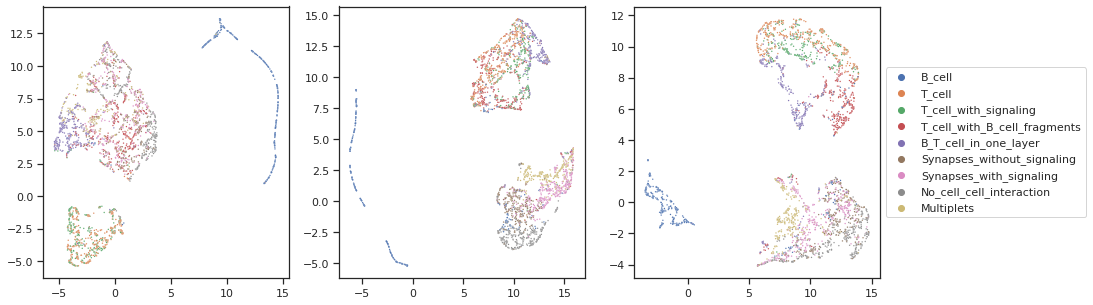

In [192]:
from umap import UMAP

fig, ax = plt.subplots(ncols = 3, figsize=(15,5))

X_transformed = StandardScaler().fit_transform(df_features.loc[train_index, tree_based_top_features])
X_transformed = UMAP(n_components=2, n_jobs=-1).fit_transform(X_transformed)
ax[0] = sns.scatterplot(x=X_transformed[:,0],
                        y=X_transformed[:,1],
                        hue=metadata.loc[train_index,"label"],
                        hue_order=set_of_interesting_classes,
                        s=2,
                        ax=ax[0])
ax[0].legend().remove()


X_transformed = StandardScaler().fit_transform(df_features.loc[train_index, permute_based_top_features])
X_transformed = UMAP(n_components=2, n_jobs=-1).fit_transform(X_transformed)
ax[1] = sns.scatterplot(x=X_transformed[:,0],
                        y=X_transformed[:,1],
                        hue=metadata.loc[train_index,"label"],
                        hue_order=set_of_interesting_classes,
                        s=2,
                        ax=ax[1])
ax[1].legend().remove()

X_transformed = StandardScaler().fit_transform(df_features.loc[train_index, shap_based_top_features])
X_transformed = UMAP(n_components=2, n_jobs=-1).fit_transform(X_transformed)
ax[2] = sns.scatterplot(x=X_transformed[:,0],
                        y=X_transformed[:,1],
                        hue=metadata.loc[train_index,"label"],
                        hue_order=set_of_interesting_classes,
                        s=2,
                        ax=ax[2])
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))


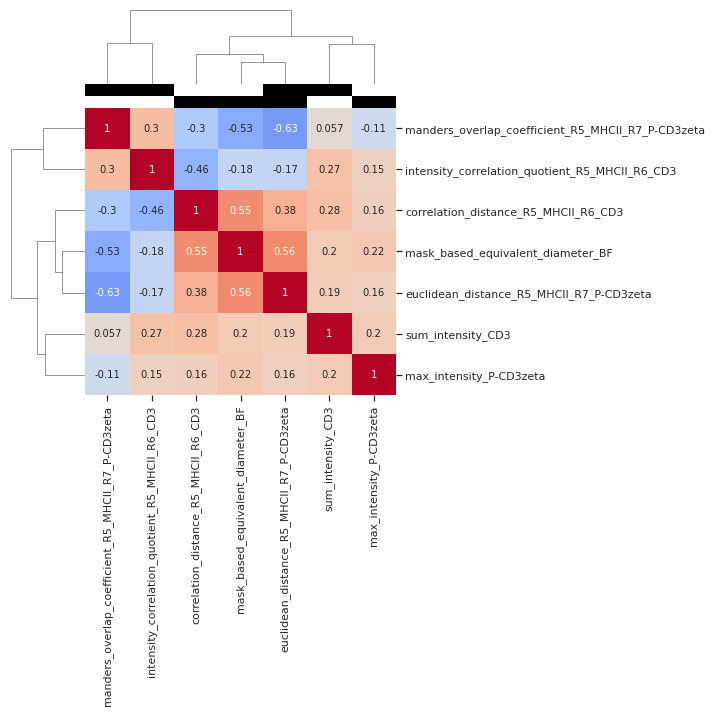

In [195]:
corr_features = df_features.loc[train_index, all_features].corr()

row_colors1 = []
row_colors2 = []
row_colors3 = []

for col in all_features:
    if col in tree_based_top_features:
        row_colors1.append("black")
    else:
        row_colors1.append("white")
        
        
    if col in shap_based_top_features:
        row_colors2.append("black")
    else:
        row_colors2.append("white")
            
        
    

cm = sns.clustermap(corr_features,
                    vmax = 1.,
                    vmin=-1,
                    center = 0,
                    cmap="coolwarm",
                    #linewidths=0.1,
                    annot=True,
                    #row_colors=[row_colors1, row_colors2, row_colors3],
                    col_colors=[row_colors1, row_colors2],
                   )
cm.cax.set_visible(False)

<AxesSubplot:>

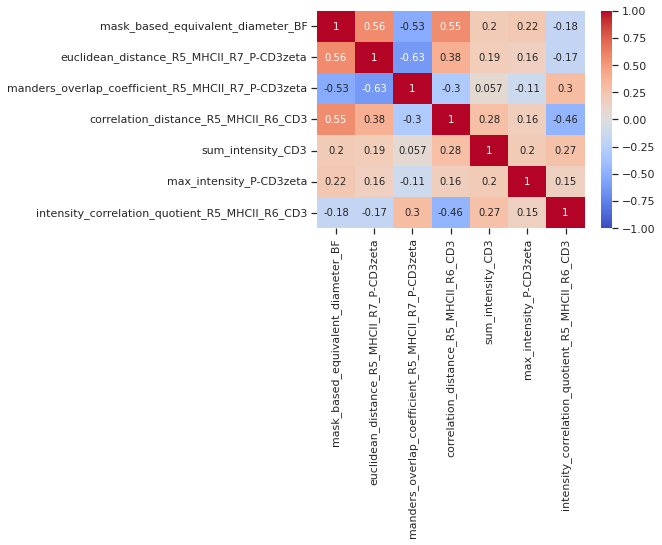

In [194]:
corr_features = df_features.loc[train_index, all_features].corr()

sns.heatmap(corr_features, vmax = 1., vmin=-1, center = 0, cmap="coolwarm", annot=True)

# SHAP on the best model

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       190
           1       0.90      0.92      0.91       200
           2       0.91      0.83      0.87       148
           3       0.95      0.94      0.94       189
           4       0.89      0.93      0.91       161
           5       0.83      0.88      0.85       147
           6       0.88      0.89      0.89       196
           7       0.96      0.96      0.96       182
           8       0.95      0.92      0.93       154

    accuracy                           0.92      1567
   macro avg       0.92      0.92      0.92      1567
weighted avg       0.92      0.92      0.92      1567

------------------------------------------------------------
No information rate: 0.13
matthews correlation coeff: 0.91
Cohen Kappa score: 0.91
Accuracy: 0.92 & balanced Accuracy: 0.92
macro F1 score: 0.92 & micro F1 score: 0.92
macro Precision score: 0.92 & micro Precision score: 0.92
macro Re

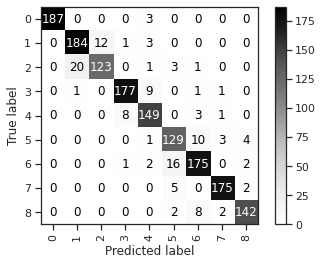

In [203]:
sns.set(font_scale = 1.0)
sns.set_style("ticks")
classification_complete_report(xgb, 
                               df_features.loc[test_index, classification_indx],
                               metadata.loc[test_index, "label"].replace(label_map))

In [205]:
preds = xgb.predict( df_features.loc[test_index, classification_indx])



In [214]:
test_data = pd.DataFrame()
test_data["label"] = metadata.loc[test_index, "label"]
test_data["label_mapped"] = metadata.loc[test_index, "label"].replace(label_map)
test_data["pred"] = preds == metadata.loc[test_index, "label"].replace(label_map)


In [215]:
test_data

label  label_mapped   pred
87          B_T_cell_in_one_layer             4   True
152       Synapses_with_signaling             6  False
201                        T_cell             1   True
723                        B_cell             0   True
734      No_cell_cell_interaction             7   True
...                           ...           ...    ...
1005444                    B_cell             0   True
1005537                    B_cell             0   True
1005577  No_cell_cell_interaction             7   True
1005694                    T_cell             1   True
1005813     T_cell_with_signaling             2   True

[1567 rows x 3 columns]

In [209]:
import shap

selected_features = xgb.steps[1][1].selected_features

X_transformed = xgb.steps[0][1].transform(df_features.loc[test_index, classification_indx])

X_transformed = xgb.steps[1][1].transform(X_transformed)


selected_feature_names = df_features.loc[test_index, classification_indx].columns[selected_features].tolist()
 
X_transformed = pd.DataFrame(X_transformed,
                             columns=selected_feature_names)


In [210]:
X_transformed.head()

mask_based_eccentricity_BF  mask_based_equivalent_diameter_BF  \
0                   -0.964405                          -0.350240   
1                    0.356909                           0.517406   
2                   -1.652341                          -1.153512   
3                   -1.154195                           0.286509   
4                    0.882753                           0.473545   

   mask_based_euler_number_BF  mask_based_extent_BF  \
0                   -0.169812              1.116254   
1                   -0.169812             -1.138960   
2                   -0.169812              0.769487   
3                   -0.169812             -0.981399   
4                   -0.169812             -1.715397   

   mask_based_feret_diameter_max_BF  mask_based_filled_area_BF  \
0                         -0.608870                  -0.434863   
1                          0.314790                   0.371695   
2                         -1.116637                  -1.002441   
3                          0.208133                   0.137432   
4                          0.401157                   0.326100   

   mask_based_major_axis_length_BF  mask_based_orientation_BF  \
0                        -0.616925                  -0.726941   
1                         0.233041                  -0.612272   
2                        -1.120967                  -1.862471   
3                        -0.228846                   0.545284   
4                         0.531338                  -0.918198   

   mask_based_perimeter_BF  mask_based_perimeter_crofton_BF  ...  \
0                -0.539300                        -0.541497  ...   
1                 0.410012                         0.401949  ...   
2                -1.072031                        -1.070935  ...   
3                 0.271477                         0.297274  ...   
4                 0.455594                         0.447250  ...   

   max_intensity_ratio_F-Actin_R5_R6  sum_intensity_ratio_MHCII_R5_R6  \
0                          -0.467936                         0.545400   
1                           0.218618                        -0.726030   
2                          -0.117240                         1.483171   
3                          -1.121074                        -1.100391   
4                          -0.194362                        -0.982330   

   mean_intensity_ratio_MHCII_R5_R6  max_intensity_ratio_MHCII_R5_R6  \
0                          0.545400                        -0.331842   
1                         -0.726030                        -0.148738   
2                          1.483171                         0.888076   
3                         -1.100391                        -0.508244   
4                         -0.982330                        -0.238508   

   sum_intensity_ratio_CD3_R5_R6  mean_intensity_ratio_CD3_R5_R6  \
0                       1.521792                        1.521792   
1                      -0.581008                       -0.581008   
2                      -0.578881                       -0.578881   
3                      -1.223771                       -1.223771   
4                      -1.109634                       -1.109634   

   max_intensity_ratio_CD3_R5_R6  sum_intensity_ratio_P-CD3zeta_R5_R6  \
0                      -0.189260                             1.522641   
1                      -0.036231                            -0.502489   
2                      -0.152987                            -0.779426   
3                      -0.324347                            -1.277714   
4                      -0.131735                            -1.102948   

   mean_intensity_ratio_P-CD3zeta_R5_R6  max_intensity_ratio_P-CD3zeta_R5_R6  
0                              1.522641                            -0.213905  
1                             -0.502489                            -0.080698  
2                             -0.779426                            -0.199520  
3                             

In [223]:
explainer = shap.TreeExplainer(xgb.steps[-1][1])

In [230]:
shap_values = explainer.shap_values(X_transformed.iloc[1:2,:])

In [231]:
np.array(shap_values).shape

(9, 1, 155)

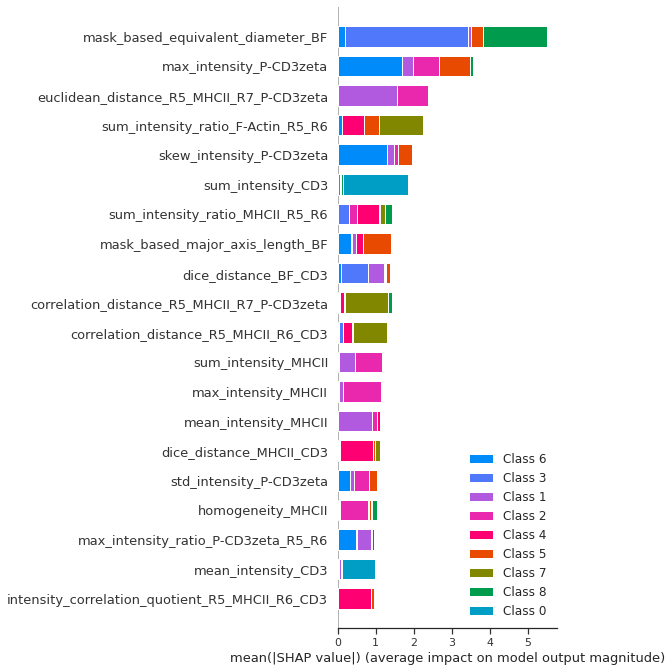

In [233]:
shap.summary_plot(shap_values, X_transformed.iloc[1:2,:])

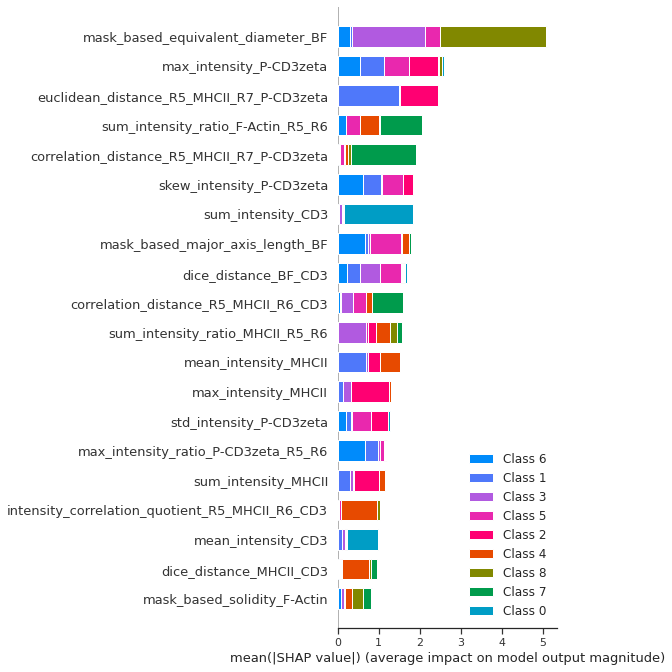

In [225]:
shap.summary_plot(shap_values, X_transformed)

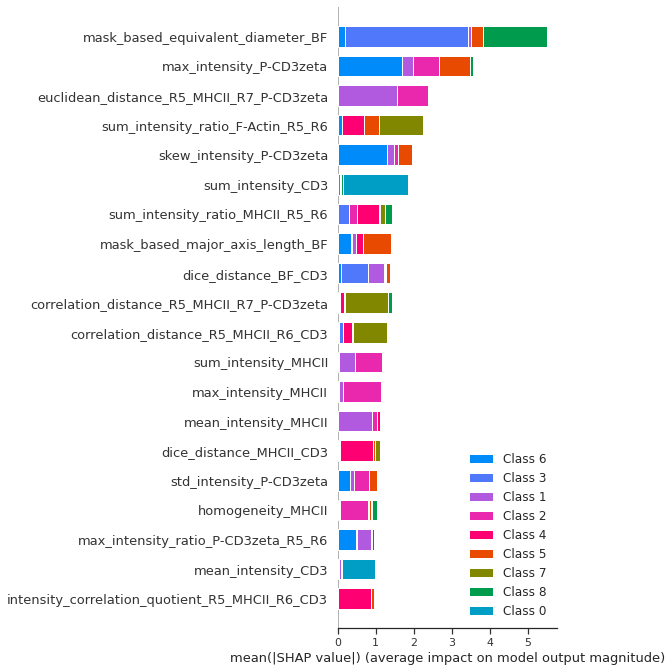

In [213]:
shap.summary_plot(shap_values, X_transformed)

87            B_T_cell_in_one_layer
152         Synapses_with_signaling
201                          T_cell
723                          B_cell
734        No_cell_cell_interaction
                     ...           
1005444                      B_cell
1005537                      B_cell
1005577    No_cell_cell_interaction
1005694                      T_cell
1005813       T_cell_with_signaling
Name: label, Length: 1567, dtype: object

In [234]:
explainer.expected_value

[0.10449898,
 0.8645402,
 0.52834016,
 0.5582029,
 0.44344988,
 0.33849883,
 0.6300473,
 0.7498801,
 0.6571898]

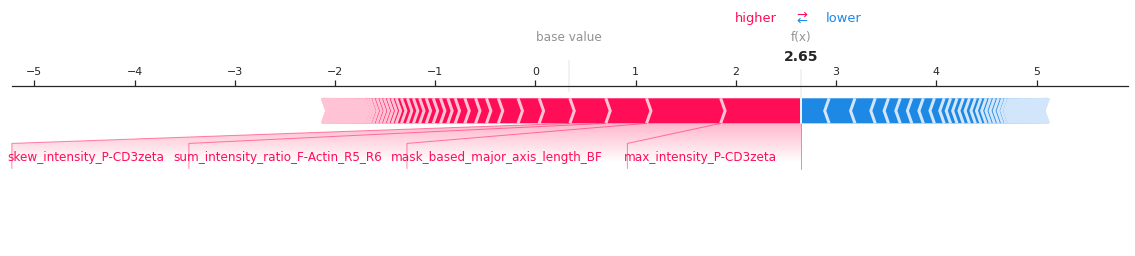

In [235]:
shap.force_plot(explainer.expected_value[5], shap_values[5],  matplotlib=True, feature_names=selected_feature_names )

In [236]:
shap_test = explainer(X_transformed)

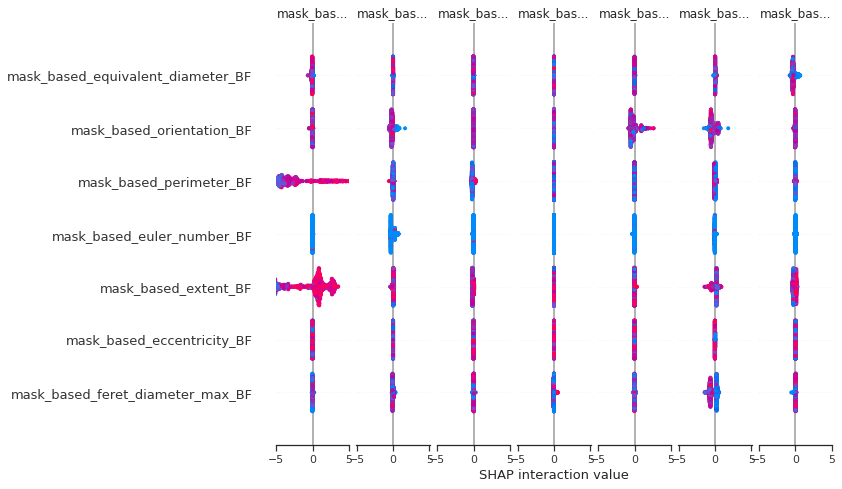

In [237]:
shap.summary_plot(shap_test.values, X_transformed)

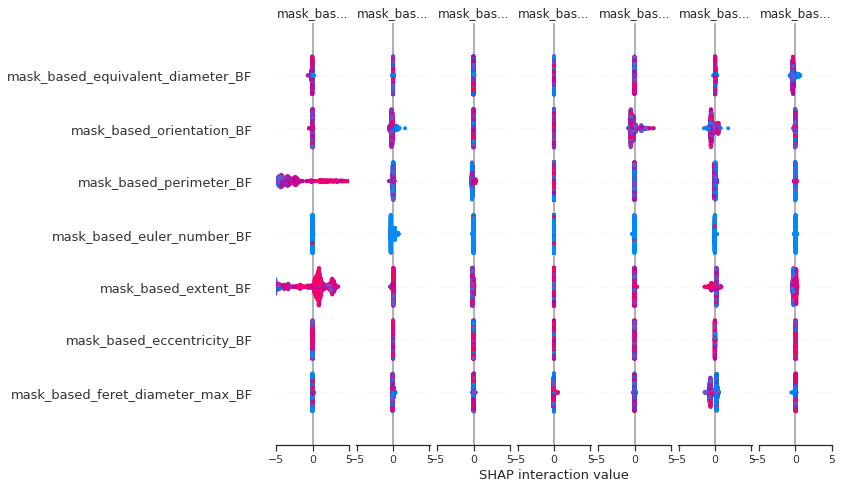

In [238]:
shap.summary_plot(shap_test, feature_names=df_features.loc[test_index, classification_indx].columns[selected_features])

## Example with LIME

In [241]:
import lime

In [248]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_transformed.to_numpy(), 
                                                   feature_names=X_transformed.columns, 
                                                   class_names=set_of_interesting_classes, 
                                                   discretize_continuous=True
                                                  )

In [255]:
exp = explainer.explain_instance(X_transformed.to_numpy()[1,:], xgb.steps[-1][1].predict_proba, num_features=3, top_labels=2)

In [256]:
exp.show_in_notebook(show_table=True, show_all=False)

In [254]:
test_data

label  label_mapped   pred
87          B_T_cell_in_one_layer             4   True
152       Synapses_with_signaling             6  False
201                        T_cell             1   True
723                        B_cell             0   True
734      No_cell_cell_interaction             7   True
...                           ...           ...    ...
1005444                    B_cell             0   True
1005537                    B_cell             0   True
1005577  No_cell_cell_interaction             7   True
1005694                    T_cell             1   True
1005813     T_cell_with_signaling             2   True

[1567 rows x 3 columns]

In [257]:
exp.show_in_notebook()